In [1]:
%pylab inline
import scipy.interpolate
import astropy.table
import astropy.units as u
import csv
import pandas as pd
import tmm
from Getindex import load_refraction_data
import numpy.polynomial.polynomial as poly
import fringe_sim
index_of_refraction = load_refraction_data(Temp = 183.)

Populating the interactive namespace from numpy and matplotlib


# Monochromator Profile for illustration

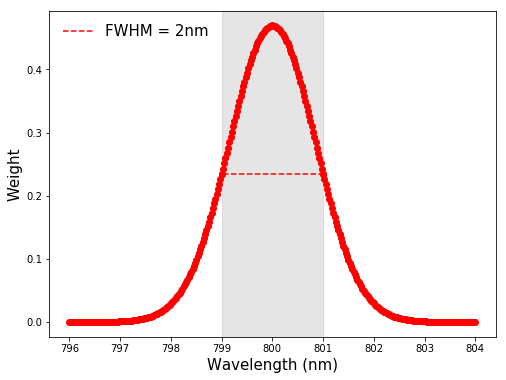

In [2]:
def gaussian(x, mu, FWHM):
    # Calculate sigma based on FWHM value 2nm
    # FWHM = 2*sqrt(2*ln2)*sigma
    sig = FWHM/(2*np.sqrt(2*np.log(2)))
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-((x - mu)/sig)**2/2)

FWHM = 2
x = np.linspace(796,804,321)
plt.figure(figsize = (8,6))
plt.plot(x,gaussian(x,800,FWHM ),'ro')
plt.axhline(np.max(gaussian(x,800,FWHM ))/2,0.39,0.61,color = 'red',ls = '--',label = 'FWHM = 2nm')
plt.plot([799,801],[np.max(gaussian(x,800,FWHM ))/2,np.max(gaussian(x,800,FWHM ))/2],'ro')
plt.axvspan(799, 801, alpha=0.2, color='gray')
plt.xlabel('Wavelength (nm)',fontsize = 15)
plt.ylabel('Weight',fontsize = 15)
plt.legend(loc = 'upper left',fontsize = 15,frameon = False);

# Multilayer simulation

In [3]:
def sim(save=None,struc = 'E2V',bandwidth = 1,avg_method = 'gaussian'):
    
    # pick up one of the CCD structures for simulation
    # Options:
    # 1. ITL sensor (Without litho-black)
    #    Layer composition and related thickness measured from https://arxiv.org/pdf/1911.09577.pdf
    # 2. E2V sensor
    #    Layer composition proposed by Criag. See fig 8(a) in the above paper by Criag.
    #
    # Both model implements Anti-Reflection coating composition given in document-8590 on LSST's Docushare site 
    # https://confluence.slac.stanford.edu/pages/viewpage.action?pageId=215845587 by Andy Rasmussen
    
    if struc == 'E2V':
        material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Vacuum')
        thickness_um = (np.inf, 0.1221,0.0441,100., 0.1, 0.3,1.,14,225, np.inf)

    elif struc == 'ITL':
        material = ['Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Vacuum']
        thickness_um = [np.inf, 0.1221,0.0441,100., 0.16, 0.341,0.41, np.inf]
        
    else:
        print("Error1: Input sturcuture Error")

    # Assume normal incidence.
    theta = 0.
    
    # Simulation wavelength range 600nm - 1000nm
    # Need small spacing to recover all fringings and smooth curve
    num_pts = 16000
    wlens = [np.linspace(600., 1000., num_pts)]
    
    # Array stores the absorption power array (as a function of wavelength)
    As = []
    
    for j,wlen in enumerate(wlens):
        
        # Initialize Reflection and Transmission Power array
        R = np.zeros_like(wlen)
        T = np.zeros_like(wlen)
        
        for i, w in enumerate(wlen):
            n_list = [index_of_refraction[m](w) for m in material]
            
            # Polarization averaged
            for pol in 'sp':
                
                # Using tmm package to do multilayer thin-film simulation
                result = tmm.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * w)
                # Store R and T results
                R[i] += 0.5*result['R']
                T[i] += 0.5*result['T']
                
        # Absorption is simply: Unity - R - T
        A = 1 - R - T
        As.append(A)
    
    # Include the finite bandwidth of monochromatic light using either 'gaussian' or 'flat' profile
    
    if avg_method == 'flat':
        bandwidth_avg = average_flat(A,avg_wlen_width=bandwidth,num_pts=num_pts)
    if avg_method == 'gaussian':
        bandwidth_avg = average_gaussian(A,avg_wlen_width=bandwidth,num_pts=num_pts)
    
    
    return(bandwidth_avg)


# Include finite bandwidth of light assuming gaussian profile
def average_gaussian (coeff,avg_wlen_width = 2,num_pts = 4000):
    # coeff: the absorption power calculated from tmm
    # avg_wlen_width: bandpass of light
    # num_pts: number of points for wavelength array in simulation, used to determine window size
    
    # number of points correspond to 1nm wavelength spacing
    scale = num_pts//400
    
    # window determines the number of points used to calculated value at the central wavelength
    # Assuming the window size for averaging to be 4 times the bandwidth or FWHM of gaussian->
    # ->to sufficiently cover the full light profile
    window = int(scale*8) 
    
    # Define the gaussian function
    def gaussian(x, mu, FWHM):
        
        # Calculate sigma based on FWHM value 2nm
        # FWHM = 2*sqrt(2*ln2)*sigma
        
        sig = FWHM/(2*np.sqrt(2*np.log(2)))

        return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-((x - mu)/sig)**2/2)
    
    # Assuming 2nm FWHM,weigh is fixed for each group of points
    # Derive the weight for 21*8 points for averaging
    x = np.linspace(796,804,321)
    
    # Assign weight to each point based on the gaussian
    weight = gaussian(x,800,avg_wlen_width)

    # Array to store the absorption power after averaging
    amp = []
    
    # Start averaging 
    for i,ab in enumerate(coeff):
        # At one central wavelength, do the averaging
        if i > (window//2+1) and i < (num_pts-window//2):
            amp.append(np.sum(coeff[i-window//2-1:i+window//2]*weight)/np.sum(weight))    
        # if not enough points for averaging (e.g hit the boundary the data array),treat as zero.
        elif i <= window//2:
            amp.append(0)
        else:
            amp.append(0)
            
    return(np.array(amp)) 




# For square profile equally weighted
def average_flat (coeff,avg_wlen_width = 2, num_pts = 4000):
    amp = []
    #data points per wavelength (1nm)
    scale = num_pts//400
    window = int(scale*avg_wlen_width)
    #print(window//2)
    for i,ab in enumerate(coeff):
        #print(i)
        if i > (window//2+1) and i < (num_pts-window//2):
            amp.append(np.mean(coeff[i-window//2-1:i+window//2]))
        elif i <= window//2:
            amp.append(0)
        else:
            amp.append(0)
    return(np.array(amp))

## First assuming 1nm bandwidth which should be narrow enough for ITL to show fringe and for E2V to show second set of fringe

In [4]:
E2V_fringe_sim = sim(save=None,struc = 'E2V', avg_method = 'gaussian')
ITL_fringe_sim = sim(save=None,struc = 'ITL',bandwidth=1, avg_method = 'gaussian')

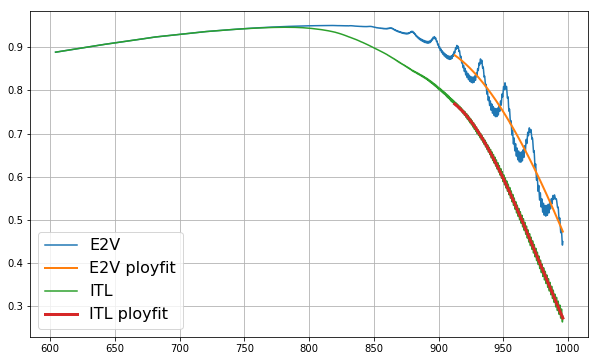

In [5]:

wlen = np.linspace(600., 1000., 16000)
plt.figure(figsize = (10,6))
plt.plot(wlen[170:-160],E2V_fringe_sim[170:-160],label = 'E2V')
x1 = wlen[12500:-160]
y1 = E2V_fringe_sim[12500:-160]
y2 = ITL_fringe_sim[12500:-160]
coefs1 = poly.polyfit(x1, y1, 3)
ffit1 = poly.polyval(x1, coefs1)
plt.plot(x1,ffit1,linewidth = 2,label = 'E2V ployfit')

plt.plot(wlen[170:-160],ITL_fringe_sim[170:-160],label = 'ITL')
coefs2 = poly.polyfit(x1, y2, 3)
ffit2 = poly.polyval(x1, coefs2)
plt.plot(x1,ffit2,linewidth =3,label = 'ITL ployfit')
plt.legend(fontsize = 16,loc = 'best')
plt.grid();

## Subtract the poly-fit from absorption power

## Fringe in ITL/E2V sensor

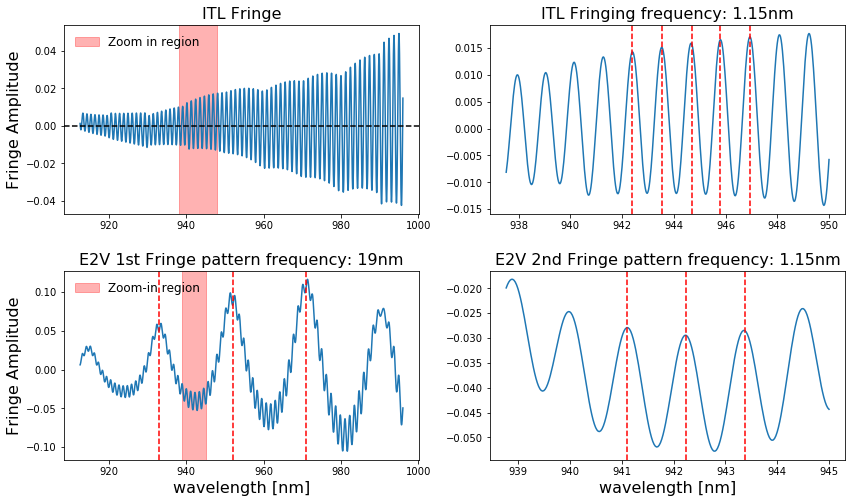

In [6]:
plt.figure(figsize = (14,8))
plt.subplots_adjust(hspace=0.3)
plt.subplot(221)
plt.title('ITL Fringe',fontsize = 16)
Fringe_amp_itl = ((y2-ffit2)/ffit2)
plt.plot(x1, Fringe_amp_itl,'-')
plt.axvspan(938,948,color = 'red',alpha = 0.3,label = 'Zoom in region')
plt.axhline(0,ls = '--',color = 'black')
plt.ylabel('Fringe Amplitude',fontsize = 16)
plt.legend(loc = 'best',frameon = False,fontsize = 12)

plt.subplot(222)
plt.plot(x1[1000:1500],Fringe_amp_itl[1000:1500])
for x in [942.4,943.53,944.7,945.8,946.95]:
    plt.axvline(x,color = 'red',ls = '--')
plt.title('ITL Fringing frequency:' + ' 1.15nm',fontsize = 16)

plt.subplot(223)
plt.title('E2V 1st Fringe pattern frequency: 19nm',fontsize = 16)
Fringe_amp_e2v = ((y1-ffit1)/ffit1)
plt.plot(x1, Fringe_amp_e2v,'-')
plt.axvspan(x1[1050],x1[1300],color = 'red',alpha = 0.3,label = 'Zoom-in region')
for x in [933,952,971]:
    plt.axvline(x,color = 'red',ls = '--')
plt.xlabel('wavelength [nm]',fontsize = 16)
plt.legend(loc = 'best',frameon = False,fontsize = 12)
plt.ylabel('Fringe Amplitude',fontsize = 16)

plt.subplot(224)
plt.title('E2V 2nd Fringe pattern frequency: 1.15nm',fontsize = 16)
plt.plot(x1[1050:1300],Fringe_amp_e2v[1050:1300])
for x in [941.1,942.23,943.37]:
    plt.axvline(x,color = 'red',ls = '--')
plt.xlabel('wavelength [nm]',fontsize = 16);

#### --------------------------------------------------------------

### From the above simulation, it's clear that to observe the complete fringe pattern for ITL and E2V, monochromatic light beamwidth < 1.2 nm is needed.
### The simulation of E2V offers one explaination to why we see two sets of fringing in some of E2V sensor in lab. The first fringing pattern (low frequency one) is due to the epoxy layer (glue between ccd and silicon support see Figure 8 in Craig's paper). The second fringing pattern (high frequency one) is due to the silicon layer. Note that the fringing frequency due to the epoxy layer is larger than 10nm, which may explain why we still see fringes in those sensors with 10nm bandwidth

#### --------------------------------------------------------------

## Now switch to 2nm bandwidth, which is the bandwidth assumed for SLAC TS8, where data were taken

In [7]:
E2V_fringe_sim = sim(save=None,struc = 'E2V', bandwidth = 2,avg_method = 'gaussian')
ITL_fringe_sim = sim(save=None,struc = 'ITL',bandwidth=2, avg_method = 'gaussian')

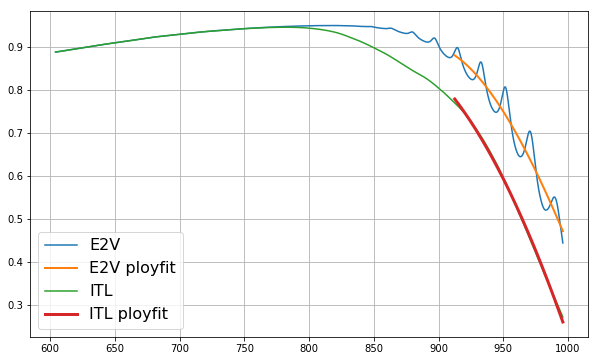

In [8]:
plt.figure(figsize = (10,6))
plt.plot(wlen[170:-160],E2V_fringe_sim[170:-160],label = 'E2V')
x1 = wlen[12500:-160]
y1 = E2V_fringe_sim[12500:-160]
y2 = ITL_fringe_sim[12500:-160]
coefs1 = poly.polyfit(x1, y1, 3)
ffit1 = poly.polyval(x1, coefs1)
plt.plot(x1,ffit1,linewidth = 2,label = 'E2V ployfit')

plt.plot(wlen[170:-160],ITL_fringe_sim[170:-160],label = 'ITL')
coefs2 = poly.polyfit(x1, y2, 2)
ffit2 = poly.polyval(x1, coefs2)
plt.plot(x1,ffit2,linewidth =3,label = 'ITL ployfit')
plt.legend(fontsize = 16,loc = 'best')
plt.grid();

Text(0, 0.5, 'Fringe Amplitude')

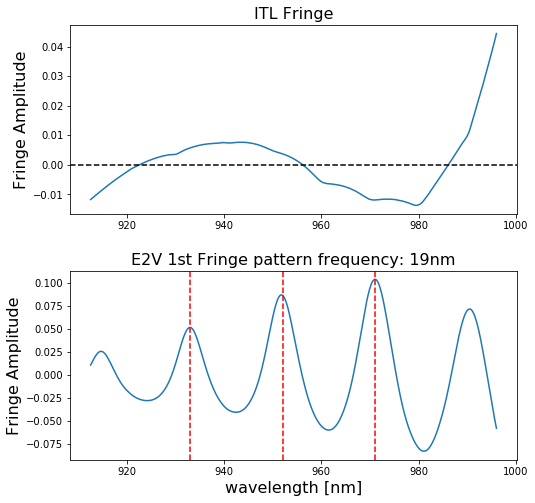

In [9]:
plt.figure(figsize = (8,8))
plt.subplots_adjust(hspace=0.3)
plt.subplot(211)
plt.title('ITL Fringe',fontsize = 16)
Fringe_amp_itl = ((y2-ffit2)/ffit2)
plt.plot(x1, Fringe_amp_itl,'-')
plt.axhline(0,ls = '--',color = 'black')
plt.ylabel('Fringe Amplitude',fontsize = 16)


plt.subplot(212)
plt.title('E2V 1st Fringe pattern frequency: 19nm',fontsize = 16)
Fringe_amp_e2v = ((y1-ffit1)/ffit1)
plt.plot(x1, Fringe_amp_e2v,'-')
for x in [933,952,971]:
    plt.axvline(x,color = 'red',ls = '--')
plt.xlabel('wavelength [nm]',fontsize = 16)
plt.ylabel('Fringe Amplitude',fontsize = 16)



#### --------------------------------------------------------------

### As it clearly shown that the 2nm bandwidth smear out the fringes effect due to the Silicon detection layer in both sensors, only the fringing pattern caused by E2V's epoxy is preserved (as explained above). This helps to explain why Fringe in ITL and 2nd fringing pattern in E2V  is not observed in SLAC TS8.

#### --------------------------------------------------------------